In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from modules import *
from sim_new import *


In [3]:
sim = Sim(9, "bturb1p0", "data_d52_l1_b5.npz")


Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.


### quick look

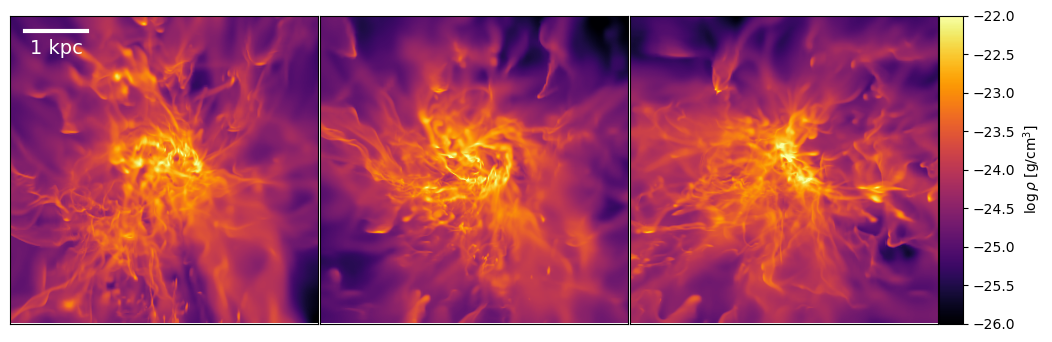

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

for i in range(3):
    img = sim.proj_axis('density', idx_axis=i)
    im = sim.plot_img(img, ax=axs[i], do_log=True, cmap='inferno', vmin=1e-26, vmax=1e-22)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
sim.add_dis_to_ax(axs[0], 1*const.kpc)
sim.add_cbar_to_fig(im, fig, label=r'$\log \rho$ [${\rm g/cm^3}$]')


[]

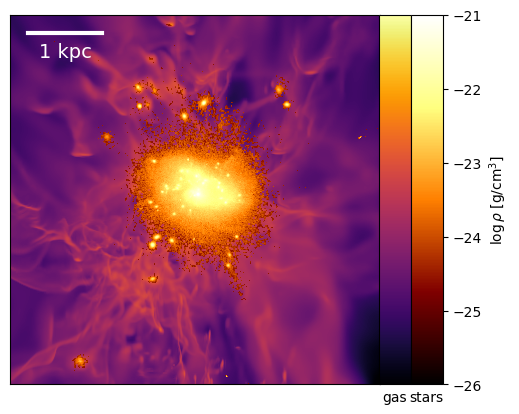

In [43]:
idx_axis = X

fig, ax = plt.figure(), plt.gca()

img = sim.proj_axis('density', idx_axis=idx_axis)
im1 = sim.plot_img(img, ax=ax, do_log=True, cmap='inferno', vmin=1e-26, vmax=1e-21)

img = sim.proj_axis('density_star', idx_axis=idx_axis)
im2 = sim.plot_img(img, ax=ax, do_log=True, cmap='afmhot', vmin=1e-26, vmax=1e-21)
    
sim.add_dis_to_ax(ax, 1*const.kpc)
cbar = sim.add_cbar_to_fig(im1, fig, bbox=[.8, .11, .05, .77])
cbar.ax.set_xlabel(r'gas')
cbar.ax.set_yticks([])
cbar = sim.add_cbar_to_fig(im2, fig, bbox=[.85, .11, .05, .77], label=r'$\log \rho$ [${\rm g/cm^3}$]')
cbar.ax.set_xlabel(r'stars')

ax.set_xticks([])
ax.set_yticks([])


### angular momentum

In [62]:
r_sph_init = 1 * const.kpc
frac_shrink = 0.99
num_iter = 10

r_sph_list = np.zeros((num_iter + 1)) 
r_sph_list[0] = r_sph_init
coord_center_list = np.zeros((num_iter + 1, 3))

for i in range(num_iter):
    coord_rel_center = sim.coord - coord_center_list[i, :, None, None, None]
    r_rel_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    cond_sph = r_rel_center < r_sph_list[i]
    coord_center_list[i + 1] = np.sum(cond_sph * sim.coord * sim.density, axis=(1,2,3)) / np.sum(cond_sph * sim.density)
    r_sph_list[i + 1] = r_sph_list[i] * frac_shrink
    print(i, end="")

coord_center = coord_center_list[-1]
coord_rel_center = sim.coord - coord_center[:, None, None, None]
r_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    

0123456789

(-300.0, 300.0)

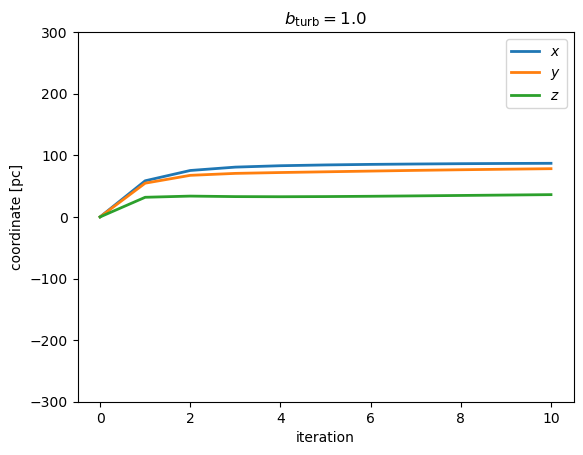

In [65]:
# plt.plot(radius_sphere_list / const.pc, color='grey', lw=2, label=r'$r_{\rm sph}$')
plt.plot(coord_center_list[:, X] / const.pc, label=r'$x$', lw=2, color='C0')
plt.plot(coord_center_list[:, Y] / const.pc, label=r'$y$', lw=2, color='C1')
plt.plot(coord_center_list[:, Z] / const.pc, label=r'$z$', lw=2, color='C2')

plt.legend()
plt.xlabel('iteration')
plt.ylabel(r'coordinate [pc]')
plt.title(sim.sim_latex)

plt.ylim(-300, 300)


Text(0.5, 1.0, '$b_{\\rm turb} = 1.0$')

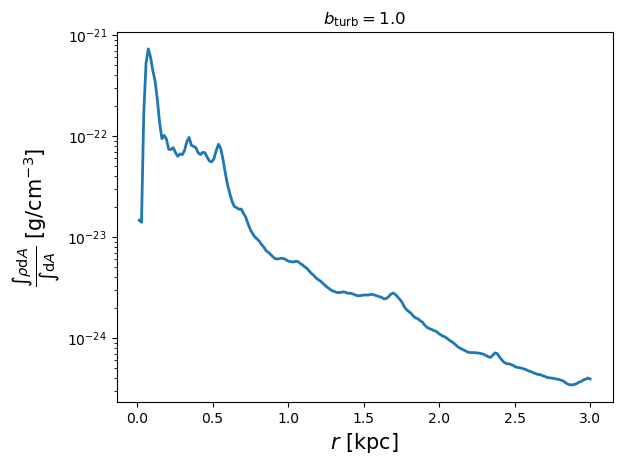

In [66]:
r_1d, rho_1d = calc_1d_profile(r_center, sim.density, extrema=(0, 3*const.kpc), do_log_x=False, nbins=200)
plt.plot(r_1d / const.kpc, rho_1d, lw=2)

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r'$\frac{\int \rho {\rm d}A}{\int {\rm d}A}$ [${\rm g/cm^{-3}}$]', fontsize=15)
plt.yscale('log')
plt.title(sim.sim_latex)


[]

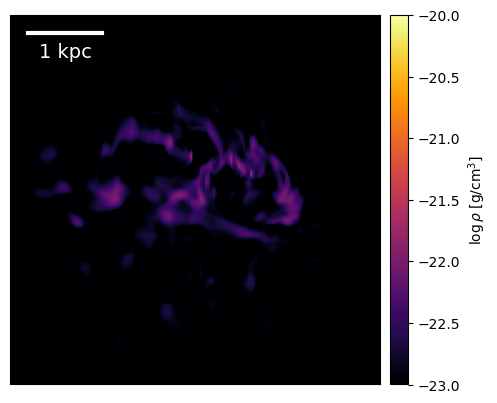

In [74]:
idx_axis = X

fig, ax = plt.figure(), plt.gca()

size_img = 2 * const.kpc
size_sample = 2 * const.kpc
img = sim.proj_axis('density', idx_axis=idx_axis, coord_center=coord_center, size_img=size_img, size_sample=size_sample)
im1 = sim.plot_img(img, ax=ax, do_log=True, cmap='inferno', vmin=1e-23, vmax=1e-20)
    
sim.add_dis_to_ax(ax, 1*const.kpc)
cbar = sim.add_cbar_to_ax(im, ax, label=r'$\log \rho$ [${\rm g/cm^3}$]')

ax.set_xticks([])
ax.set_yticks([])


[]

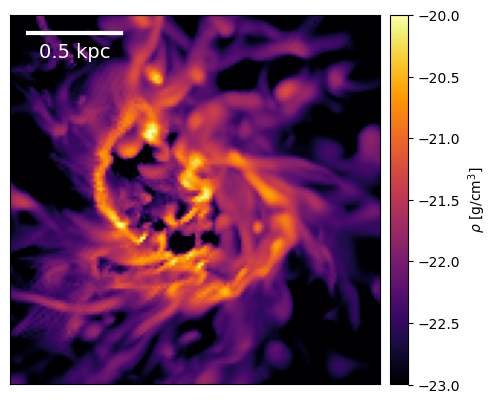

In [61]:
coord_center = np.array([0.51035391, 0.51257681, 0.49281211]) * sim.length_unit - sim.left_edge
j_disk = np.array([0.52981294, 0.81509684, 0.23434034])

size_img = 2 * const.kpc
size_sample = 2 * const.kpc
num_pxl = 128
num_sample = 10000
#vec_camera = np.cross(j_disk, np.array([1, 0, 0]))
vec_camera = j_disk
vec_north = np.array([0.5, 0.5, 0])

vec_coord1, vec_coord2, img = sim.proj_anyaxis('density', coord_center=coord_center, size_img=size_img, size_sample=size_sample, vec_camera=vec_camera, num_pxl=num_pxl, vec_north=vec_north, weight='density')

ax = plt.gca()
im = sim.plot_img(img, size_img=size_img, vmin=1e-23, vmax=1e-20, cmap='inferno', do_log=True)
sim.add_cbar_to_ax(im, ax=ax, label=r'$\rho$ [${\rm g/cm^3}$]')

sim.add_dis_to_ax(ax, 0.5*const.kpc, size_img=size_img)
ax.set_xticks([])
ax.set_yticks([])
